In [139]:
import gc
import pathlib

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

In [140]:
%run ../wmis_gnn_py/util/metis.py
%run ../wmis_gnn_py/util/gurobi_wmis.py
%run ../wmis_gnn_py/util/subgraph.py
%run ../wmis_gnn_py/util/greedy.py

# Small Erdos-Reyni Graphs

In [141]:
er_paths = list(yield_metis_filenames("../data/erdos_reyni_small/"))
er_labels = list(yield_solution_filenames("../data/erdos_reyni_small/label"))
pace_paths = list(yield_metis_filenames("../data/pace_weighted/"))

In [142]:
G = metis_to_nx(er_paths[0])

In [143]:
G_prime = G.copy()
solution_to_nx(G_prime, er_labels[0])
assert is_independent(G_prime)

opt_weight = sum(
    G_prime.nodes[v]["weight"]
    for v in G_prime.nodes
    if G_prime.nodes[v]["solution"] == 1.0
)
opt_weight

9554

In [144]:
wmis_lp(G)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 36 physical cores, 36 logical processors, using up to 32 threads
Optimize a model with 2013 rows, 200 columns and 4026 nonzeros
Model fingerprint: 0x2efff399
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 2013 rows, 200 columns, 4026 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4125662e+04   1.528150e+03   0.000000e+00      0s
     172    1.8774500e+04   0.000000e+00   0.000000e+00      0s

Solved in 172 iterations and 0.02 seconds (0.01 work units)
Optimal objective  1.877450000e+04


In [145]:
H = get_unsolved_view(G)

In [146]:
greedy_wmis(H)
assert is_independent(G)

In [147]:
sum(G.nodes[v]["weight"] for v in G.nodes if G.nodes[v]["solution"] == 1.0) / opt_weight

0.6102156164957087

# PyG

In [1]:
import torch
import torch_geometric as pyg

In [2]:
%run ../wmis_gnn_py/datasets.py

In [10]:
dataset = SmallER("../data/erdos_reyni_small/").shuffle()
print(len(dataset))

loader_train = pyg.loader.DataLoader(dataset[:800], batch_size=64, shuffle=True)
loader_eval = pyg.loader.DataLoader(dataset[800:], batch_size=64, shuffle=True)

1000


In [11]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # TODO: Define two GCNConv modules and a ReLU function.
        # The input size and output size of first GCNConv module should be in_channels and hidden_channels
        # The input size and output size of second GCNConv module should be hidden_channels and out_channels

        ############# Your code here ############
        ## (~3 line of code)
        self.conv1 = pyg.nn.GCNConv(
            in_channels=in_channels, out_channels=hidden_channels, normalize=True
        )
        self.relu = torch.nn.ReLU()
        self.conv2 = pyg.nn.GCNConv(
            in_channels=hidden_channels, out_channels=out_channels, normalize=True
        )
        self.sigmoid = torch.nn.Sigmoid()
        #########################################

    def forward(self, node_feature, edge_index):

        output = None

        # TODO: Use the modules you define in __init__ to perform message passing.
        # ReLU function should be used in the middle of two GCNConv modules.

        ############# Your code here ############
        ## (~3 line of code)
        result_conv1 = self.conv1(node_feature, edge_index)
        result_relu = self.relu(result_conv1)
        result_conv2 = self.conv2(result_relu, edge_index)
        output = self.sigmoid(result_conv2)
        #########################################

        return output

In [12]:
model = GCN(1, 10, 1).cuda()

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.BCELoss()

In [14]:
def train(model, training_set, optimizer, loss_fn):
    loss = 0

    # TODO: Define train function.
    # 1. put the model into train mode
    # 2. clear the gradients calculated from the last batch
    # 3. get the prediction by model
    # 4. calculate the loss between our predictions and the actual labels.
    # Just using nodes in train set!
    # 5. calculate the gradients of each parameter
    # 6. update the parameters by taking an optimizer step

    ############# Your code here ############
    ## (~7 line of code)
    model.train()
    optimizer.zero_grad()
    y_pred = model(data.x, data.edge_index)
    loss = loss_fn(y_pred, data.solution)
    loss.backward()
    optimizer.step()
    #########################################

    return loss

In [15]:
@torch.no_grad()
def test(model, data):
    # TODO: Define test function.
    # 1. put the model into eval mode
    # 2. get the prediction by model
    # 3. calculate the accuracy for each set
    # NOTE: the results should be a list containing the accuracy of different set

    ############# Your code here ############
    ## (~5 line of code)
    model.eval()
    y_pred = model(data.x, data.edge_index)
    pred = y_pred.gt(0.5).float()
    acc = pred.eq(data.solution).float().mean()
    #########################################

    return acc

In [16]:
from tqdm.notebook import tqdm

num_epochs = 10
epochs = list(range(1, num_epochs + 1))
train_loss, eval_acc = [], []

best_eval_acc = float("-inf")
for epoch in tqdm(epochs, position=0, leave=True, desc="epoch"):
    train_loss_curr = 0.0
    for data in tqdm(loader_train, position=1, leave=False, desc="training batch"):
        loss = train(model, data.cuda(), optimizer, loss_fn)
        train_loss_curr += loss / len(loader_train)

    eval_acc_curr = 0.0
    for data in tqdm(loader_eval, position=1, leave=False, desc="eval batch"):
        acc = test(model, data.cuda())
        eval_acc_curr += acc / len(loader_eval)

    train_loss.append(train_loss_curr)
    eval_acc.append(eval_acc_curr)

    if eval_acc_curr > best_eval_acc:
        best_eval_acc = eval_acc_curr

print(
    "after {} epochs' training, the best eval acc is {}".format(
        num_epochs, best_eval_acc
    )
)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

training batch:   0%|          | 0/13 [00:00<?, ?it/s]

eval batch:   0%|          | 0/4 [00:00<?, ?it/s]

training batch:   0%|          | 0/13 [00:00<?, ?it/s]

eval batch:   0%|          | 0/4 [00:00<?, ?it/s]

training batch:   0%|          | 0/13 [00:00<?, ?it/s]

eval batch:   0%|          | 0/4 [00:00<?, ?it/s]

training batch:   0%|          | 0/13 [00:00<?, ?it/s]

eval batch:   0%|          | 0/4 [00:00<?, ?it/s]

training batch:   0%|          | 0/13 [00:00<?, ?it/s]

eval batch:   0%|          | 0/4 [00:00<?, ?it/s]

training batch:   0%|          | 0/13 [00:00<?, ?it/s]

eval batch:   0%|          | 0/4 [00:00<?, ?it/s]

training batch:   0%|          | 0/13 [00:00<?, ?it/s]

eval batch:   0%|          | 0/4 [00:00<?, ?it/s]

training batch:   0%|          | 0/13 [00:00<?, ?it/s]

eval batch:   0%|          | 0/4 [00:00<?, ?it/s]

training batch:   0%|          | 0/13 [00:00<?, ?it/s]

eval batch:   0%|          | 0/4 [00:00<?, ?it/s]

training batch:   0%|          | 0/13 [00:00<?, ?it/s]

eval batch:   0%|          | 0/4 [00:00<?, ?it/s]

after 10 epochs' training, the best eval acc is 0.8174803853034973


In [24]:
dataset[12].solution.sum() / len(dataset[0].solution)

tensor(0.1900)

# PACE 2019 Competition Graphs

In [11]:
rows = []

filepaths = list(yield_metis_filenames("../data/pace_unweighted/"))
# print(filepaths)
for filepath in tqdm(filepaths):
    path = filepath.resolve()
    # print(path)
    G = metis_to_nx(path)
    rows.append(pd.Series(summarize_graph(G, path.stem)))

    gc.collect()

df_pace = pd.DataFrame(rows).set_index("name")
df_pace

100%|██████████| 200/200 [54:53<00:00, 16.47s/it]   


,n_nodes,n_edges,avg_deg,n_components,n_isolates,sum_weights,treewidth_min_degree,average_clustering
name,,,,,,,,
vc-exact_001,6160,40207,13.054221,32,0,6160,131,0.697
vc-exact_002,51795,41253,1.592934,10542,0,51795,1,0.000
vc-exact_003,60541,48418,1.599511,12123,0,60541,1,0.000
vc-exact_004,8114,26013,6.411881,6,0,8114,1612,0.013
vc-exact_005,200,798,7.980000,1,0,200,85,0.051
...,...,...,...,...,...,...,...,...
vc-exact_196,1534,126082,164.383312,1,0,1534,1342,0.221
vc-exact_197,1534,127011,165.594524,1,0,1534,1336,0.207
vc-exact_198,1150,80072,139.255652,1,0,1150,1008,0.226


In [12]:
df_pace.to_csv("pace_unweighted.csv")

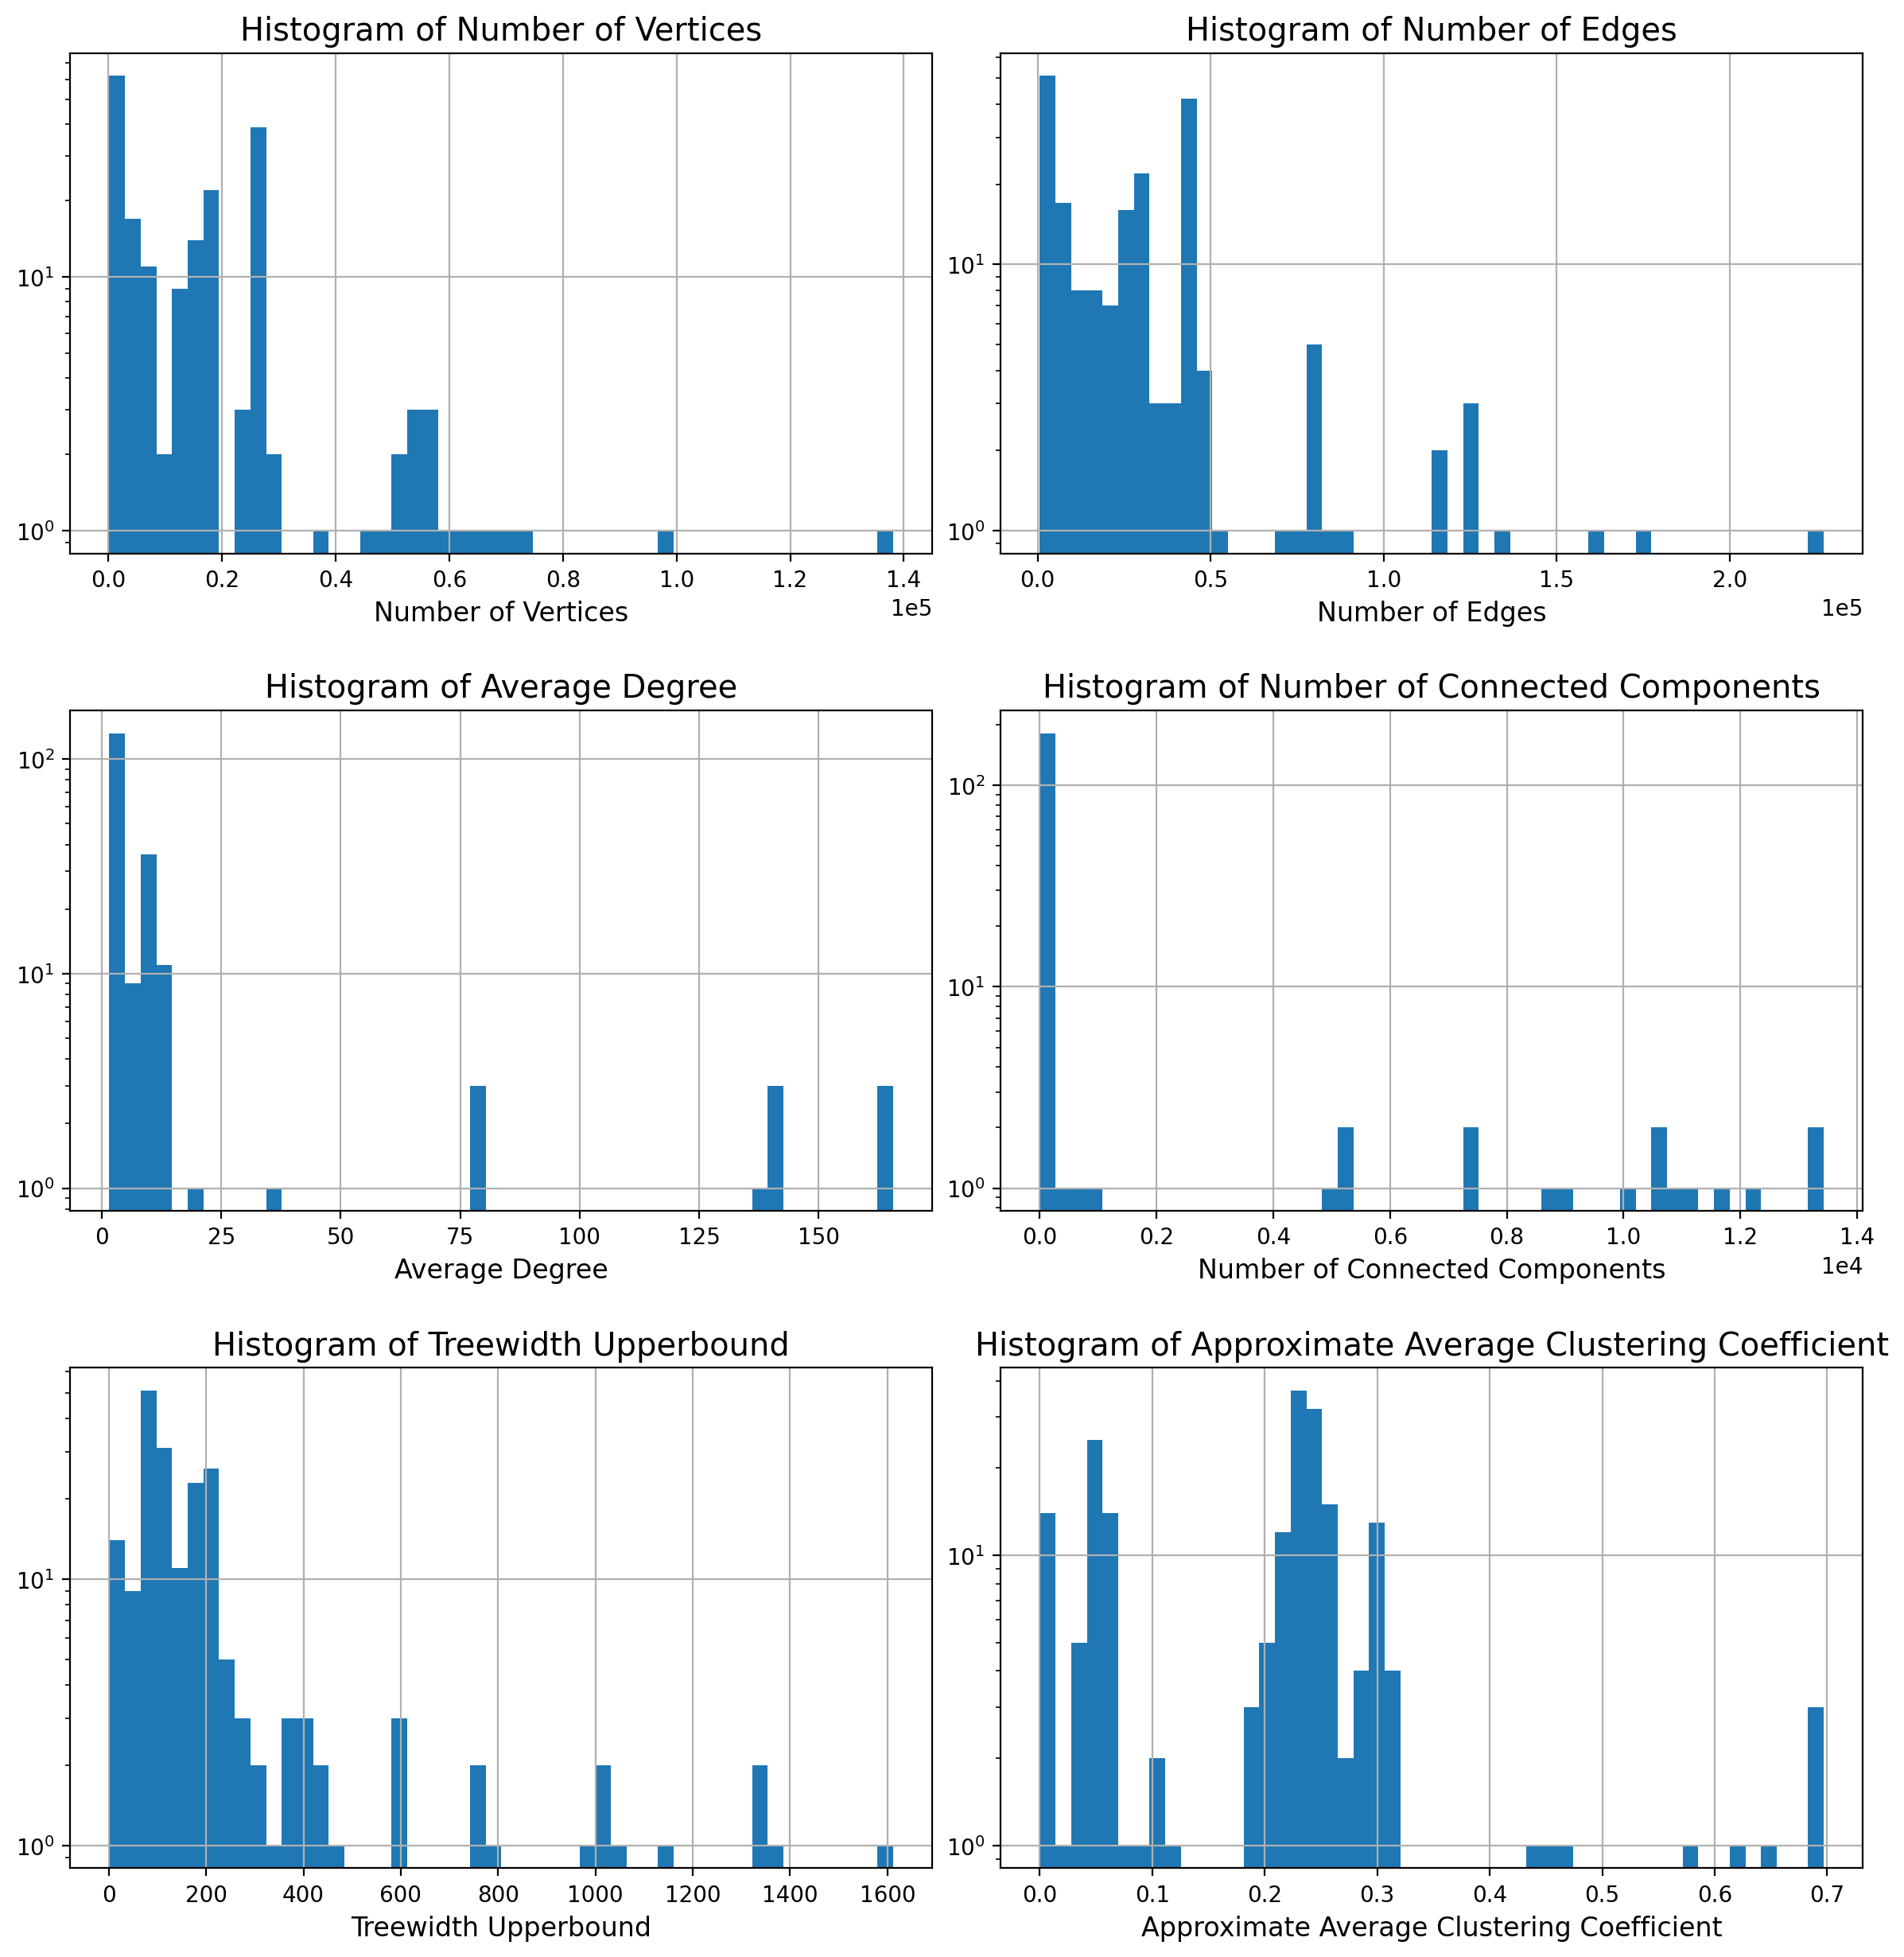

In [4]:
df_pace = pd.read_csv("pace_unweighted.csv")

plot_graph_df(df_pace)
plt.savefig("pace_unweighted.pdf", bbox_inches="tight")